In [ ]:
import networkx as nx
import numpy as np
from queue import PriorityQueue
import ipywidgets as widgets
import random
from copy import deepcopy
import torch
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import logging

In [ ]:


# Configure logging to output to PyCharm's console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def add_node_with_edges(graph, node_name):
    """
    Add a node to the graph and allow the user to input related edges with direction using widgets in Jupyter Notebook.
    Displays immediate edge information on addition and logs actions to console.

    Parameters:
    graph (nx.DiGraph): The directed graph to add the node and edges to.
    node_name (str): The name of the node to add.

    Returns:
    None
    """
    # Add the node to the graph
    graph.add_node(node_name)
    display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
    logger.info(f"Node '{node_name}' has been added to the graph.")

    # Define output widget
    global node_dropdown, user_text, root_text, direction_dropdown, output
    output = widgets.Output()

    # Function to handle edge addition
    def add_edge(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")
            
            try:
                # Get widget values
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value
                
                # Validate probabilities
                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    return
                
                # Prepare edge information
                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"
                
                # Add edge based on direction
                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"
                
                # Display and log edge info immediately
                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                display_widgets()  # Redisplay widgets for next edge
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    # Function to handle stopping
    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    # Function to display widgets
    def display_widgets():
        with output:
            clear_output(wait=True)
            # Get list of existing nodes
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return
            
            # Create widgets
            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(
                options=existing_nodes,
                description='Target Node:',
                disabled=False
            )
            user_text = widgets.FloatText(
                value=0.0,
                description='User Prob:',
                style={'description_width': 'initial'}
            )
            root_text = widgets.FloatText(
                value=0.0,
                description='Root Prob:',
                style={'description_width': 'initial'}
            )
            direction_dropdown = widgets.Dropdown(
                options=["To Target", "From Target", "Bidirectional"],
                description='Edge Direction:',
                disabled=False
            )
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            # Assign button callbacks with debug logging
            def on_add_button_clicked(b):
                logger.info("Add Edge button event triggered.")
                add_edge(b)
            
            def on_stop_button_clicked(b):
                logger.info("Stop button event triggered.")
                stop_adding(b)

            add_button.on_click(on_add_button_clicked)
            stop_button.on_click(on_stop_button_clicked)

            # Display widgets and initial message
            display(HTML(f"<b>Adding edges from/to '{node_name}':</b>"))
            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # Initial display of widgets
    display(output)
    display_widgets()

In [ ]:
# Original graph setup
G_original = nx.DiGraph()
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)

G_new = G_original.copy()
add_node_with_edges(G_new, "New node")



In [ ]:

# Draw the graph
plt.figure(figsize=(30,25))
pos = nx.spring_layout(G_new)

nx.draw(G_new, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=2000, font_size=20, font_weight='bold')

# Draw edge labels with weights
edge_labels = {(u, v): f"u={d['user']},r={d['root']}" for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=20)
plt.savefig("graph.png")
plt.show()

In [ ]:
# Attacker's greedy attack with randomizer
def global_weighted_random_attack(graph, honeypot_nodes, goal):
    captured = {"Attacker"}
    path = ["Attacker"]

    while True:
        # Collect all uncaptured neighbors of compromised nodes
        neighbors = []
        edge_weights = []
        source_nodes = []

        for compromised_node in captured:
            for neighbor in graph.successors(compromised_node):
                if neighbor not in captured:
                    edge_data = graph[compromised_node][neighbor]
                    weight = edge_data['user'] + edge_data['root']
                    neighbors.append(neighbor)
                    edge_weights.append(weight)
                    source_nodes.append(compromised_node)

        if not neighbors:
            break

        # Normalize weights to probabilities
        total_weight = sum(edge_weights)
        if total_weight == 0:
            break
        probabilities = [w / total_weight for w in edge_weights]

        # Choose next node randomly based on probabilities
        chosen_idx = random.choices(range(len(neighbors)), weights=probabilities, k=1)[0]
        chosen_node = neighbors[chosen_idx]
        source_node = source_nodes[chosen_idx]

        # Add to path and captured
        path.append(chosen_node)
        captured.add(chosen_node)

        # Check stopping conditions
        if chosen_node in honeypot_nodes or chosen_node == goal:
            break

    return path, captured


# Attacker's greedy attack with randomizer
def greedy_attack_priority_queue(graph, honeypot_nodes, goal):
    captured = {"Attacker"}
    path = ["Attacker"]
    pq = PriorityQueue()
    for neighbor in graph.successors("Attacker"):
        weight = max(graph["Attacker"][neighbor]['user'], graph["Attacker"][neighbor]['root'])
        randomizer = random.uniform(0, 1)  # Randomizer for tie-breaking
        pq.put((-weight, -randomizer, neighbor))  # Sort by -weight, -randomizer, neighbor

    while not pq.empty():
        neg_weight, neg_randomizer, to_node = pq.get()
        weight = -neg_weight
        randomizer = -neg_randomizer
        if to_node in honeypot_nodes:  # Stop at honeypot node
            path.append(to_node)
            captured.add(to_node)
            break
        if to_node not in captured:
            captured.add(to_node)
            path.append(to_node)
            if to_node == goal:
                break
            for next_node in graph.successors(to_node):
                if next_node not in captured:
                    next_weight = max(graph[to_node][next_node]['user'], graph[to_node][next_node]['root'])
                    next_randomizer = random.uniform(0, 1)  # New randomizer for each edge
                    pq.put((-next_weight, -next_randomizer, next_node))
    return path, captured


In [ ]:
# 1. Environment Setup
# Environment class
class NetworkSecurityEnv:
    def __init__(self, G_new, attack_fn, goal="Data Server"):
        self.G_new = G_new
        self.attack_fn = attack_fn
        self.goal = goal
        self.nodes = [n for n in G_new.nodes if n not in ["Attacker", goal]]
        self.num_nodes = len(self.nodes)
        self.state = np.zeros(self.num_nodes, dtype=np.float32)
        self.node_to_idx = {node: idx for idx, node in enumerate(self.nodes)}

    def reset(self):
        self.state = np.zeros(self.num_nodes, dtype=np.float32)
        return self.state

    def step(self, action):
        honeypot_nodes = []
        G = deepcopy(self.G_new)

        for i in range(2):
            node_idx = np.argmax(action[i])
            if action[i, node_idx] == 0:
                node_idx = random.randint(0, self.num_nodes - 1)
            node = self.nodes[node_idx]
            honeypot = f"Honeypot_{i}"
            honeypot_nodes.append(honeypot)
            G.add_node(honeypot)
            G.add_edge(node, honeypot, user=0.8, root=0.8)

        path, captured = self.attack_fn(G, honeypot_nodes, self.goal)

        new_state = np.zeros(self.num_nodes, dtype=np.float32)
        reward = 0
        done = False

        if any(h in captured for h in honeypot_nodes):
            reward = 1
            done = True
        elif self.goal in captured:
            reward = -1
            done = True

        for node in captured:
            if node in self.node_to_idx:
                new_state[self.node_to_idx[node]] = 1

        self.state = new_state
        return new_state, reward, done, path, captured

    def get_action_space_size(self):
        return self.num_nodes * (self.num_nodes - 1)

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_space_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_space_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
class DQNWithBias(nn.Module):
    def __init__(self, base_model, num_old, num_new):
        super().__init__()
        self.model = base_model
        self.num_old = num_old
        self.num_new = num_new

        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.beta = nn.Parameter(torch.Tensor([0]))

    def forward(self, x):
        q_raw = self.model(x)  

        q_old = q_raw[:, :self.num_old]
        q_new = q_raw[:, self.num_old:]  # node mới
        q_new_corrected = self.alpha * q_new + self.beta

        q_corrected = torch.cat([q_old, q_new_corrected], dim=1)
        return q_corrected


In [ ]:
# Helper to convert action index to 2D array
def index_to_action(index, num_nodes):
    # Map index to two distinct node indices
    first = index // (num_nodes - 1)
    second = index % (num_nodes - 1)
    if second >= first:
        second += 1
    action = np.zeros((2, num_nodes), dtype=np.float32)
    action[0, first] = 1
    action[1, second] = 1
    return action

def action_to_index(action, num_nodes):
    # Convert 2D action array to index
    first = np.argmax(action[0])
    second = np.argmax(action[1])
    if second >= first:
        second -= 1
    return first * (num_nodes - 1) + second 

In [ ]:
def save_model(policy_net, target_net, optimizer, episode, path='dqn_model.pth'):
    checkpoint = {
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode
    }
    torch.save(checkpoint, path)
    print(f'Model saved to {path}')

In [ ]:
# 3. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (
            np.array(state),
            np.array(action),
            np.array(reward),
            np.array(next_state),
            np.array(done)
        )

    def __len__(self):
        return len(self.buffer)

In [341]:
old_num_nodes = 6
new_num_nodes = 7
old_action_space_size = old_num_nodes * (old_num_nodes - 1)
new_action_space_size = new_num_nodes * (new_num_nodes - 1)
model_old =  DQN(old_num_nodes, old_action_space_size)
model_load = torch.load("./Saved_Model/dqn_model.pth")
model_old.load_state_dict(model_load['policy_net_state_dict'])
model_new = DQN(new_num_nodes, new_action_space_size)

with torch.no_grad():
    model_new.fc1.weight[:, :old_num_nodes] = model_old.fc1.weight  
    model_new.fc1.bias = model_old.fc1.bias

    model_new.fc2.load_state_dict(model_old.fc2.state_dict())
    model_new.fc3.load_state_dict(model_old.fc3.state_dict())
    
    model_new.fc4.weight[:old_num_nodes] = model_old.fc4.weight[:old_num_nodes]
    model_new.fc4.bias[:old_num_nodes] = model_old.fc4.bias[:old_num_nodes]
    
    model_new.fc1.weight[:, old_num_nodes:] = torch.nn.init.xavier_uniform_(
        model_new.fc1.weight[:, old_num_nodes:])  # Khởi tạo Xavier cho node mới
    # Khởi tạo trọng số cho action mới trong fc4
    model_new.fc4.weight[old_action_space_size:] = torch.nn.init.xavier_uniform_(
        model_new.fc4.weight[old_action_space_size:])
    model_new.fc4.bias[old_action_space_size:] = torch.zeros_like(
        model_new.fc4.bias[old_action_space_size:])  # Khởi tạo bias bằng 0


In [342]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo môi trường và mô hình
env = NetworkSecurityEnv(G_new, global_weighted_random_attack)
model = DQNWithBias(model_new, old_num_nodes, new_num_nodes)

# Chỉ fine-tune tầng cuối (fc4)
for name, param in model.model.named_parameters():
    param.requires_grad = (("fc4" or "fc1") in name)

# Chỉ tối ưu alpha và beta
optimizer = torch.optim.Adam([model.alpha, model.beta], lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-5)
criterion = nn.CrossEntropyLoss()


replay_buffer = ReplayBuffer(capacity=10000)


batch_size = 8
target_update_freq = 8
num_episodes = batch_size * 20
losses = []

epsilon = 0.3
successes = 0
for episode in range(1, num_episodes + 1):
    state = env.reset()
    done = False
    total_loss = 0
    episode_steps = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        if random.random() < epsilon:
            action_idx = random.randint(0, new_action_space_size - 1)
        else:
            with torch.no_grad():
                q_values = model(state_tensor)
                if torch.isnan(q_values).any() or torch.isinf(q_values).any():
                    print(f"Warning: NaN or Inf in Q-values at episode {episode}")
                    break
                action_idx = q_values.argmax().item()

        action = index_to_action(action_idx, new_num_nodes)
        next_state, reward, done, path, captured = env.step(action)
        
        replay_buffer.push(state, action_idx, reward, next_state, done)
        state = next_state
        episode_steps += 1
        
        honeypot_nodes = []
        for i in range(2):
            node_idx = np.argmax(action[i])
            honeypot_nodes.append(env.nodes[node_idx])
        print("Episode:",episode )
        if reward == 1:  # Honeypot bẫy được kẻ tấn công
            print(path)
            print(f"Success\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
            successes += 1

        elif reward == -1:  # Kẻ tấn công đạt mục tiêu
            print(path)
            print(f"Failed\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
            
        # Train từ buffer
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions)
            rewards_tensor = torch.FloatTensor(rewards)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones)

            if not (actions_tensor >= 0).all() or not (actions_tensor < new_action_space_size).all():
                print(f"Invalid actions in batch at episode {episode}")
                continue

            optimizer.zero_grad()
            q_pred = model(states_tensor)

            if torch.isnan(q_pred).any() or torch.isinf(q_pred).any():
                print(f"Warning: NaN or Inf in q_pred at episode {episode}")
                continue

            with torch.no_grad():
                q_next = model(next_states_tensor)
                q_next_max = q_next.max(1)[0]
                q_target = rewards_tensor + (1 - dones_tensor) * 0.99 * q_next_max

            loss = criterion(q_pred, actions_tensor)
            loss.backward() 
            optimizer.step()
            total_loss += loss.item()

    avg_loss = total_loss / max(episode_steps, 1)
    if episode >= batch_size:
        losses.append(avg_loss)
        scheduler.step(avg_loss)

    if episode % target_update_freq == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Episode {episode}, Avg Loss: {avg_loss:.4f}, Alpha: {model.alpha.item():.4f}, Beta: {model.beta.item():.4f}, LR: {current_lr:.6f}")
dsp = (successes / num_episodes)*100
print(f"\nDefense success probability: {dsp:.2f}%") 

Episode: 1
['Attacker', 'Pad', 'Web Server', 'Honeypot_0']
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

Episode: 2
['Attacker', 'Pad', 'Web Server', 'Honeypot_0']
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

Episode: 3
['Attacker', 'Pad', 'Host 1', 'Host 3', 'Web Server', 'Host 2', 'File Server', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypots connected to: ['Host 3', 'File Server']

Episode: 4
['Attacker', 'Pad', 'Host 1', 'Web Server', 'Host 3', 'Data Server']
Failed
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

Episode: 5
['Attacker', 'Pad', 'Web Server', 'Honeypot_0']
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

Episode: 6
['Attacker', 'Web Server', 'Pad', 'Honeypot_0']
Su

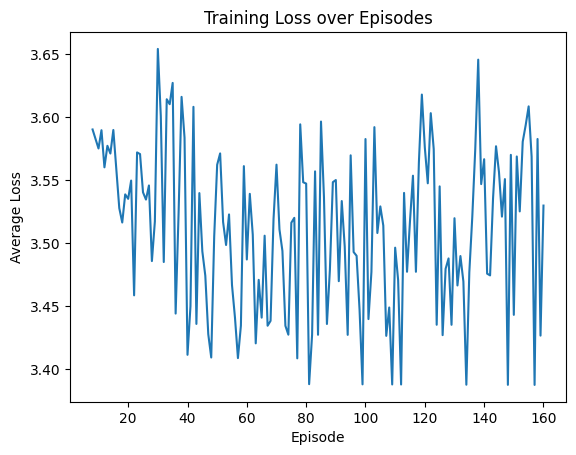

In [343]:
plt.plot(range(batch_size, num_episodes + 1), losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Training Loss over Episodes')
plt.show()


In [344]:
def evaluate_model(model, env, num_episodes=1000):
    successes = 0
    for episode in range(1,num_episodes+1):
        state = env.reset()
        done = False
        episode_honeypots = []  # Lưu vị trí honeypot trong episode
        
        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = model(state_tensor)
                action_idx = q_values.argmax().item()
                action = index_to_action(action_idx, new_num_nodes)
            next_state, reward, done, path, captured = env.step(action)
            print (path)
            print (captured)    
            state = next_state
            honeypot_nodes = []
            for i in range(2):
                node_idx = np.argmax(action[i])
                honeypot_nodes.append(env.nodes[node_idx])
            print("Episode:",episode )
            if reward == 1:  # Honeypot bẫy được kẻ tấn công
                successes += 1
                print(f"Success\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
                break
            elif reward == -1:  # Kẻ tấn công đạt mục tiêu
                print(f"Failed\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
                break
        
        
    dsp = (successes / num_episodes ) * 100
    print(f"\nDefense success probability: {dsp:.2f}%")

evaluate_model(model, env)

['Attacker', 'Pad', 'Host 1', 'Web Server', 'Host 2', 'Honeypot_0']
{'Host 2', 'Attacker', 'Host 1', 'Honeypot_0', 'Pad', 'Web Server'}
Episode: 0
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

['Attacker', 'Pad', 'Honeypot_0']
{'Honeypot_0', 'Pad', 'Attacker'}
Episode: 1
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

['Attacker', 'Pad', 'Host 1', 'Web Server', 'Honeypot_0']
{'Attacker', 'Host 1', 'Honeypot_0', 'Pad', 'Web Server'}
Episode: 2
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

['Attacker', 'Web Server', 'Honeypot_1']
{'Web Server', 'Honeypot_1', 'Attacker'}
Episode: 3
Success
Honeypots: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Pad', 'Web Server']

['Attacker', 'Web Server', 'Pad', 'Host 1', 'Honeypot_0']
{'Attacker', 'Host 1', 'Honeypot_0',